The Hamiltonian for the model is

$$
H = - \sum_{<ij>} J_{ij} s_i s_j - \sum_{i} B_i s_i
$$

$\sum_{<ij>}$ indicates a summation over all neighboring pairs of spins (concrete example next),
$J_{ij}$ is the strenght of the interaction between the pair $ij$,
$B_i$ is the external magnetic field at site $i$.

And for our purposes, we will work in a world where there is no external magnetic field,
and where the coupling between neighbroing pairs of spins if constant.

$$
H = - J \sum_{<ij>} s_i s_j
$$

Now let us show how to compute the energy.
We will be doing it by computing the energy between transitions (we are doing it this way because we just happen to know that this will come in handy later on).


If a sping is up, $u$, then its value is +1.
So here below we have 4 pairs of nearest neighboards where $\sum_{<ij>} s_i s_j = 1 + 1 + 1 + 1 = 4$, so $H = -J4$.
From there try double checking the rest.

```
              u                      u
E = -4J     u u u    ->   E = 4J   u d u
              u                      u
```
$\Delta E = 4J - -4J = 8J$ and so $-\beta \Delta E = - 8J \beta$


```
              u                        u
E = -2J     d u u     ->    E = 2J   d d u
              u                        u
```
$\Delta E = 2J - -2J = 4J$ and so  $-\beta \Delta E = - 4J \beta$.


```
              u                        u
E =  0J     d u u     ->    E = 0J   d d u
              d                        d
```
$\Delta E = 0J - 0J = 0J$ and so $-\beta \Delta E = - 0J \beta = 0$.


```
              d                         d
E = 2J      d u u     ->    E = -2J   d d u
              d                         d
```
$\Delta E = -2J - 2J = -4J$ and so $-\beta \Delta E = 4J \beta$.

```
              d                        d
E = 4J      d u d     ->   E = -4J   d d d
              d                        d
```
$\Delta E = -4J - 4J = -8J$ and so $-\beta \Delta E = 8J \beta$.

If you rack your brain you'll see that these are all the possible states and transitions, when we flip one spin at a time.

The critical temperature for the 2D model has been analytically obtained and is

$$
T_c = \frac{2J}{\log(1 + \sqrt{2})} \approx 2.269 J
$$

or
$$
\beta_c \approx \frac{0.4407}{J}
$$

See [Wikipedia: Onsager's exact solution](https://en.wikipedia.org/wiki/Ising_model#Onsager's_exact_solution).

# Metropolis Algorithm

Single site is updated at a time:
    a. Probability of generating such as state is $1/N$.

The detailed condition for Markov Chains Monte Carlos is
$$
\frac{P(\mu \rightarrow \nu)}{P(\nu \rightarrow \mu)}
= \frac{g(\mu \rightarrow \nu) A(\mu \rightarrow \nu)}{g(\nu \rightarrow \mu) A(\mu \rightarrow \nu)}
= \frac{A(\mu \rightarrow \nu)}{A(\mu \rightarrow \nu)}
$$

Where $g$ is the probability of generating a given state and $A$ is the probability of accepting the transition.

Remember that the more stringent expression of detailed balance to guarantee static equilibirum is written as
$$
p_mu P(\mu\rightarrow\nu) = p_nu P(\nu\rightarrow\mu)
$$

and since the probabilities $p_mu$ and $p_nu$ are $e^{-\beta E_mu}/Z$ and $e^{-\beta E_nu}/Z$ respectively,

$$
\frac{P(\mu \rightarrow \nu)}{P(\nu \rightarrow \mu)}
= \frac{A(\mu \rightarrow \nu)}{A(\mu \rightarrow \nu)}
= \frac{p_\nu}{p_\mu}
= e^{-\beta (E_\nu - E_\mu)}
$$

Note that if $E_\nu \leq E_\mu$, then $e^{-\beta (E_\nu - E_\mu)}$, then the argument of the exponent will be zero or positive, so $e^{+(\ldots)} \geq 1$.
And if $E_\nu > E_\mu$, then $e^{-\beta (E_\nu - E_\mu)}$ will looke like $e^{-(\ldots)} < 1$.
Which intuitevely makes sense, transitioning to a state $\nu$ from a state $\mu$ is favored when the end state $\nu$ has a lower energy (rememeber that the exponents are proportional to the probability of the given state).

Thus, the Metropolis algorithm 
$$
A(\mu \rightarrow \nu)
=
\begin{cases}
    1                                                    & \text{if } E_\nu \leq E_\mu \quad(\Delta E \leq 0) \\
    e^{-\beta (E_\nu - E_\mu)} = e^{-\beta \Delta E} \   & \text{if } E_\nu > E_\mu \quad(\Delta E > 0)
\end{cases}
$$

**Note:** there is a potential for a simplification here! if you go back to the beginning where we documented all the 5 possible transitions, only 2 of them meet the criteria of $E_\nu > E_\mu$ ($\Delta E > 0$).
So we only really need to compute two exponentials $e^{-4J\beta}$ and $e^{-8J\beta}$, so we could pre-compute them instead of calling a special function.
And we do do this in `Lattice.cpp` in the `Lattice(unsigned int x, unsigned int y, unsigned int RNSeed)` constructor.

# Wolff Cluster Algorithm

## Swendsen-Wang Algorithm

1. The entire lattice is partitioned into non-overlapping clusters. Each cluster contains a region where all spins are aligned in the same direction.
2. Each cluster is flipped with probability 1/2.

## Wolff Cluster Algorithm

Create only a single cluster of aligned spins that does not include the entire lattice most of the time.

1. **Randomly** select an initial seed spin.
2. The initial seed spin forms the kernel for the cluster.
3. **Probabilistically** add to the cluster all of the seed's neighbours that have the same spin.
4. Recursively consider all of the neighbours of the seed's neighbours.
5. Stop when all the properly-aligned neighbour sites have been tested.
6. Flip the cluster to create a new state. This new state is always accepted.

The Wolff cluster algorithms then moves the issue of optimizing the acceptance probabilities to
the generation of an acceptance probability (by probabilistically adding sites to a cluster).

So in this case $A(\mu\rightarrow\nu) = A(\nu\rightarrow\mu) = 1$, and we know we want to land in
$$
\frac{P(\mu \rightarrow \nu)}{P(\nu \rightarrow \mu)}
= \frac{g(\mu \rightarrow \nu)}{g(\mu \rightarrow \nu)}
= e^{-\beta (E_\nu - E_\mu)}
$$

With the Wolff algorithmn, the non-local change in energy is when the cluster is flipped and the spins at the borders of the cluster that used to be aligned end up pointing in the opposite direction.
Then, if $P_+$ is the probability of a neighbouring spin being added to a cluster, the make the argument that the selection probability $g$ is proportional to the number of independent Bernoulli trials of a neighbouring spin not being added

$$
g(\mu\rightarrow\nu) \propto (1-P_+)^n
$$

So,

$$
\frac{P(\mu \rightarrow \nu)}{P(\nu \rightarrow \mu)}
= \frac{g(\mu \rightarrow \nu)}{g(\mu \rightarrow \nu)}
= (1-P_+)^{n-m}
= e^{-\beta (E_\nu - E_\mu)}
$$

where $m$ is are the neighbours around the edges of the cluster that were pointing in the opposite direction but after the flip end up being aligned.
So going backwards (flipping the cluster back) is $g(\nu\rightarrow\mu) \propto (1-P_+)^m$.

The other thing to take into account is that if we go from $u u \rightarrow u d$, then the energy went from $-J(1) \rightarrow -J(-1)$, same if we went from $d d \rightarrow u d$. In both cases the change in energy is of $J + J = 2J$.
So the energy rises by $2J$ for each $n$ spin that used to be aligned but it no longer is after the cluster flip.
Thus,

$$
(1-P_+)^{n-m}
= (e^{-2J\beta})^{n-m}
= e^{-\beta (E_\nu - E_\mu)}
$$

Which coincidentally also tells us that,
$$
P_+ = 1 - e^{-2J\beta}
$$

# Autocorrelation Time

$\tau$ is informally, the similarity between observations of a random variable (the "state" of our system) as a function of the time lag between them.
It is roughly how long it takes for a system to evolve into a new state which is statistically independent from the initial state.

Let's say that we have some observable $Q$ (a mathematician/statistician will talk about random variables).
And let's introduce the **time-displaced autocorrelation function** $\chi(t)$,

$$
\chi(t)
= \frac{1}{t_{max} - t} \left( \sum^{t_{max}-t}_{t^\prime = 0} Q(t^\prime) Q(t+t^\prime) \right) - \langle Q \rangle^2
$$

Note that we have a sum because we are working with time series measurements of our random variables.
Also see that $t_{max}$ is the total number of measurements made during a simulation.

We assume that the correlation, and consequently $\chi(t)$,  decreases exponentially as time passes by.
So we assume a generic form such as $\chi(t) = A e^{-t/\tau}$.
Thus,
$$
\frac{\chi(t)}{\chi(0)} = e^{-t/\tau}
$$

So solving for $\tau$ gives us,
$$
\tau = -t / \log\left( \frac{\chi(t)}{\chi(0)} \right)
$$
or
$$
\tau = t / \log\left( \frac{\chi(0)}{\chi(t)} \right)
$$

To compute $\tau$ then, we would look at the ratio $\chi(t) / \chi(0)$ in the domain until $\chi(t)$ deviates from an exponential decay curve, $\chi(t) < \chi(t+1)$, or when $\chi(t) , 0$.
Within the domain in-scope then compute $\tau_t$ and then take the average.

# Lattice Simulations of Nonperturbative Quantum Field Theories: Issing Model

The rest of this notebook will cover the Ising model simulation implemented in
[Lattice Simulations of Nonperturbative Quantum Field Theories]https://inspirehep.net/literature/1386200)
by David Schaich.

Given what we have already discussed we can begin with the implementation of the Ising model in this work.

## Precompute Optimizations

The first step in the Isign model simulation is a series of metropolis steps for equilibration with a handful of optimization thrown in.

The first one, is that as we just saw during our energy counting excersie, there are only 5 possible transitions and froom those trnasitions 3 will always lead us to a lower energy level, and the other 2 will be accepted probabilistically (we generate a $U \sim U[0,1]$ and if $u$ is smaller than the Boltsmann factor $e^{-\beta\Delta E}$, then we accept the move.

The even more interesting thing is that there is somewhat of a symmetry around the energy transitions.
For example, looking at the 3 cases in which we will always accept the transition, their initial energies are 0J, 2J, ad 4J.
And these states end up with energies 0J, -2J, and -4J after a spin has been flipped.
Then the ones that are accepted probabilitistically start with energy -4J and -2J and end up with energy 4J and 2J respectively.

Right away a couple optimizations show up:
1. We only need to pre-compute 2 Bolzmann factors, $e^{-4J\beta}$ and $e^{-8J\beta}$ to account for the probabilistic acceptances.
2. We can tell if we can accept a transition right away based on the initial energy: if the initial energy is 0J, 2J, or 4J then we accept right away.
    a. A note here, in the thesis, the sign of the energy is actually flipped so we are looking not at the initial energy but at the final one. This is done for purely cosmetic reasons.

## Lattice Considerations

There is another interesting bit to take a look at:

```c++
int Lattice::calcHalfenergy(unsigned int site) {
    getHalfNeighbours(site);

    return -lattice[site] * (lattice[nextX] + lattice[nextY]);
}

double Lattice::calcTotalEnergy() {
    totalEnergy = 0;
    for (unsigned int i = 0; i < latticeSize; i++)
        totalEnergy += calcHalfenergy(i);
    return totalEnergy / latticeSize;
}
```

The interesting energy counting being done by the author is to avoid double counting interactions in the lattice.
And this is something we should always be on the loop out for!

In [3]:
# Figure 5.1 is the measurement of E vs. T on a 32x32 lattice.
# The range os Temperatures tested is from a little above 0 to 5.
# Figure 5.2 is Magnetization vs. T. With the same ranges as above.
# Figure 5.3 is the same but of specific heat vs. T.
# Figure 5.4 is susceptibility vs. T.

# Figure 5.5 is a 128x129 lattice.

# Figure 5.8 and 5.9 visualize susceptibility for lattices of size 32^2, 64^2, 128^2, 256^2, 512^2, 1024^2.

In [1]:
!make Metropolis

g++  -c Metropolis.cpp -o Metropolis.o
g++ -o Metropolis HashTable.o Lattice.o Metropolis.o -L/usr/local/lib -Wl,-rpath,/usr/local/lib -lgsl -lgslcblas -lm


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess

# Replicating Figure 2.1

This is found on page 6.

In [13]:
!ls *.csv autocor-*

autocor-0-1000.txt  autocor-0-3000.txt
autocor-0-2000.txt  correlation-time.csv


In [14]:
!rm correlation-time.csv
!rm autocor-*

In [15]:
with open("correlation-time.csv", "a") as output:
    output.write("xdim,ydim,equil,stat,seed,T,autocorrt,avgE,stdE,avgMAbs,stdM,c,m,avgM,scaleF\n")

In [16]:
for steps in [1_000, 1_500, 2_000, 2_500, 3_000, 4_000, 5_000]:
    xdim     = str(32)
    ydim     = str(32)
    equil_n  = str(0)
    stat_n   = str(steps)
    T        = str(220)    # This is divided by 100 by Metropolis.
    autocorF = f"autocor-{equil_n}-{stat_n}.txt"  # TXT file containing the autocorrelation time series.

    result = subprocess.run(['./Metropolis', xdim, ydim, equil_n, stat_n, T, autocorF], stdout=subprocess.PIPE)

    print(f'running with {steps} steps...')
    #print(f'stdout: {result.stdout}')
    print(f'stderr: {result.stderr}')

    with open("correlation-time.csv", "a") as output:
        output.write(result.stdout.decode("utf-8"))

running with 1000 steps...
stderr: None
running with 1500 steps...
stderr: None
running with 2000 steps...
stderr: None
running with 2500 steps...
stderr: None
running with 3000 steps...
stderr: None
running with 4000 steps...
stderr: None
running with 5000 steps...
stderr: None


In [17]:
!cat correlation-time.csv

xdim,ydim,equil,stat,seed,T,autocorrt,avgE,stdE,avgMAbs,stdM,c,m,avgM,scaleF
32,32,0,1000,220,2.200000,7.189535,-1.542176,0.145382,0.779881,0.010864,1.429520,3.820308,0.779881,0.008208
32,32,0,1500,220,2.200000,8.214422,-1.540978,0.132306,0.776893,0.010095,1.386274,4.330888,0.776893,0.009305
32,32,0,2000,220,2.200000,8.855812,-1.540169,0.124725,0.778339,0.008615,1.417633,3.900770,0.778339,0.008381
32,32,0,2500,220,2.200000,10.640867,-1.537914,0.123950,0.774370,0.008889,1.449445,4.320162,0.774370,0.009282
32,32,0,3000,220,2.200000,20.764761,-1.531749,0.145822,0.759527,0.014580,1.570055,7.147762,0.635348,0.015357
32,32,0,4000,220,2.200000,21.878513,-1.536401,0.134116,0.768518,0.012033,1.491091,6.161002,0.277639,0.013237
32,32,0,5000,220,2.200000,19.930826,-1.540354,0.121963,0.774344,0.009708,1.460402,5.502486,0.062581,0.011822


In [18]:
!ls autocor-*

autocor-0-1000.txt  autocor-0-2000.txt	autocor-0-3000.txt  autocor-0-5000.txt
autocor-0-1500.txt  autocor-0-2500.txt	autocor-0-4000.txt


In [20]:
data1 = np.loadtxt('autocor-0-1000.txt')

In [21]:
data1.size, data1.min(), data1.max()

(1000, -1.32489, 30.3627)

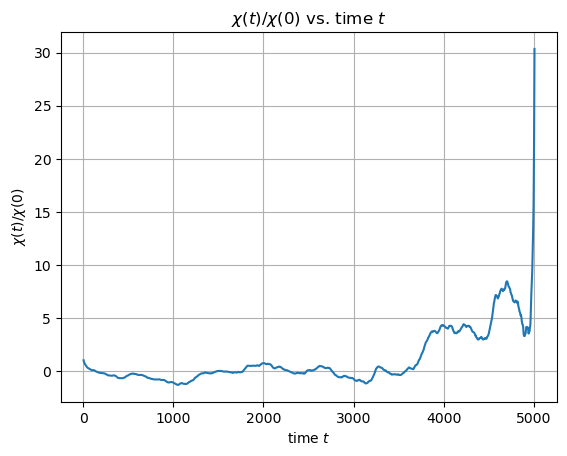

In [22]:
# We are multiplying by 5 because we only took measurements every 5 steps in the code.
t = np.linspace(1, data1.size+1, data1.size) * 5
plt.plot(t, data1)

plt.title('$\chi(t)/\chi(0)$ vs. time $t$')
plt.xlabel('time $t$')
plt.ylabel('$\chi(t)/\chi(0)$')
plt.grid(True) 
plt.show()

In [23]:
def exp_decay_lim(array):
    """ exp_decay_lim returns the index of where the autocorrelation data
    measurements deviate from an actual exponential decay function:

    1.) When a value becomes negative.
    2.) When a value is suddenly greater than the previous one.
    3.) If none of the above, the it returns the array size (the last element).
    """
    lim = 0
    for i in range(1, array.size):
        if array[i] < 0 or array[i] > array[i-1]:
            print(i)
            return i
    return array.size

In [32]:
data1 = np.loadtxt('autocor-0-1000.txt')
lim1 = exp_decay_lim(data1)

data2 = np.loadtxt('autocor-0-1500.txt')
lim2 = exp_decay_lim(data2)

data3 = np.loadtxt('autocor-0-2000.txt')
lim3 = exp_decay_lim(data3)

data4 = np.loadtxt('autocor-0-2500.txt')
lim4 = exp_decay_lim(data4)

19
25
22
34


In [39]:
df = pd.read_csv('correlation-time.csv')
df

,xdim,ydim,equil,stat,seed,T,autocorrt,avgE,stdE,avgMAbs,stdM,c,m,avgM,scaleF
0,32,32,0,1000,220,2.2,7.189535,-1.542176,0.145382,0.779881,0.010864,1.429520,3.820308,0.779881,0.008208
1,32,32,0,1500,220,2.2,8.214422,-1.540978,0.132306,0.776893,0.010095,1.386274,4.330888,0.776893,0.009305
2,32,32,0,2000,220,2.2,8.855812,-1.540169,0.124725,0.778339,0.008615,1.417633,3.900770,0.778339,0.008381
3,32,32,0,2500,220,2.2,10.640867,-1.537914,0.123950,0.774370,0.008889,1.449445,4.320162,0.774370,0.009282
4,32,32,0,3000,220,2.2,20.764761,-1.531749,0.145822,0.759527,0.014580,1.570055,7.147762,0.635348,0.015357
5,32,32,0,4000,220,2.2,21.878513,-1.536401,0.134116,0.768518,0.012033,1.491091,6.161002,0.277639,0.013237
6,32,32,0,5000,220,2.2,19.930826,-1.540354,0.121963,0.774344,0.009708,1.460402,5.502486,0.062581,0.011822


In [41]:
df['autocorrt'][0]

7.189535

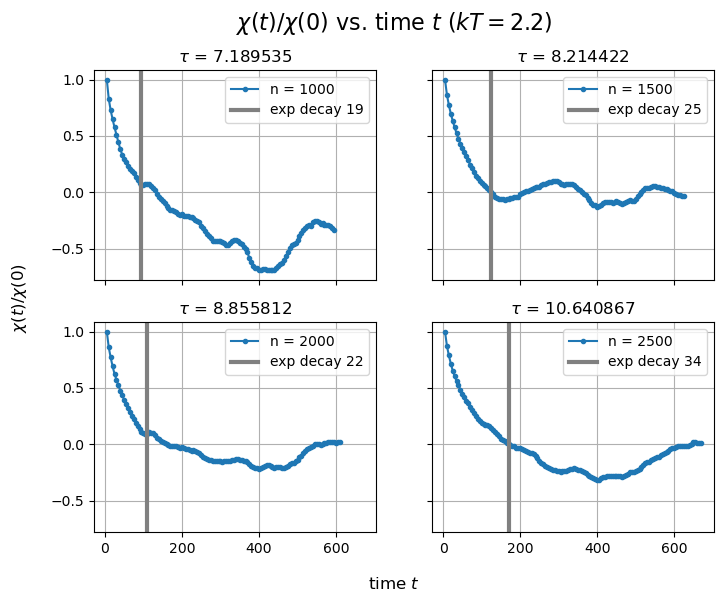

In [54]:
upper_bound1 = lim1 + 100
upper_bound2 = lim2 + 100
upper_bound3 = lim3 + 100
upper_bound4 = lim4 + 100

t1 = np.linspace(1, upper_bound1, upper_bound1) * 5
t2 = np.linspace(1, upper_bound2, upper_bound2) * 5
t3 = np.linspace(1, upper_bound3, upper_bound3) * 5
t4 = np.linspace(1, upper_bound4, upper_bound4) * 5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

ax1.plot(t1, data1[:upper_bound1], marker='.', label=f'n = {df["stat"][0]}')
ax2.plot(t2, data2[:upper_bound2], marker='.', label=f'n = {df["stat"][1]}')
ax3.plot(t3, data3[:upper_bound3], marker='.', label=f'n = {df["stat"][2]}')
ax4.plot(t4, data4[:upper_bound4], marker='.', label=f'n = {df["stat"][3]}')

ax1.axvline(x = lim1 * 5, color = 'grey', label = f'exp decay {lim1}', linewidth=3)
ax2.axvline(x = lim2 * 5, color = 'grey', label = f'exp decay {lim2}', linewidth=3)
ax3.axvline(x = lim3 * 5, color = 'grey', label = f'exp decay {lim3}', linewidth=3)
ax4.axvline(x = lim4 * 5, color = 'grey', label = f'exp decay {lim4}', linewidth=3)

ax1.set_title(f'$\\tau$ = {df["autocorrt"][0]}')
ax1.grid(True) 
ax1.legend()

ax2.set_title(f'$\\tau$ = {df["autocorrt"][1]}')
ax2.grid(True) 
ax2.legend()

ax3.set_title(f'$\\tau$ = {df["autocorrt"][2]}')
ax3.grid(True) 
ax3.legend()

ax4.set_title(f'$\\tau$ = {df["autocorrt"][3]}')
ax4.grid(True) 
ax4.legend()

fig.supxlabel('time $t$')
fig.supylabel('$\chi(t)/\chi(0)$')

fig.suptitle('$\chi(t)/\chi(0)$ vs. time $t$ ($kT = 2.2$)', fontsize=16)

#plt.title('$\chi(t)/\chi(0)$ vs. time $t$')
#plt.xlabel('time $t$')
#plt.ylabel('$\chi(t)/\chi(0)$')
#plt.grid(True) 
#plt.legend()
plt.show()